# SVD Analysis of Model Weight Matrices

Analyze the singular value distribution of weight matrices to understand their effective rank and potential for low-rank compression.

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union, Optional, Tuple
from pathlib import Path

In [13]:
def load_model_weights(checkpoint_path: str) -> dict:
    """Load model weights from checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file
        
    Returns:
        State dict with model weights
    """
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
    if 'model_state_dict' in checkpoint:
        return checkpoint['model_state_dict']
    else:
        return checkpoint


def list_weight_matrices(state_dict: dict) -> List[str]:
    """List all weight matrices in the model.
    
    Args:
        state_dict: Model state dict
        
    Returns:
        List of weight matrix names (2D tensors only)
    """
    matrices = []
    for name, param in state_dict.items():
        if param.dim() == 2:
            matrices.append(name)
    return matrices


def get_weight_matrix(state_dict: dict, name: str) -> torch.Tensor:
    """Get a specific weight matrix by name.
    
    Args:
        state_dict: Model state dict
        name: Parameter name (e.g., 'layers.0.attn.qkv.weight')
        
    Returns:
        Weight tensor
    """
    if name not in state_dict:
        raise KeyError(f"Weight '{name}' not found. Use list_weight_matrices() to see available weights.")
    return state_dict[name]

In [ ]:
def compute_svd(weight: torch.Tensor) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute SVD of a weight matrix.
    
    Args:
        weight: 2D weight tensor
        
    Returns:
        Tuple of (U, singular_values, Vh)
    """
    W = weight.float().numpy()
    U, S, Vh = np.linalg.svd(W, full_matrices=False)
    return U, S, Vh


def analyze_singular_values(
    checkpoint_path: str,
    layer_names: List[str],
    figsize: Tuple[int, int] = (14, 5),
    log_scale: bool = True,
    normalize: bool = True,
) -> dict:
    """Analyze and plot singular values for specified layers.
    
    Args:
        checkpoint_path: Path to model checkpoint
        layer_names: List of layer names to analyze
        figsize: Figure size
        log_scale: Use log scale for y-axis
        normalize: Normalize singular values (divide by max)
        
    Returns:
        Dict mapping layer names to their singular values
    """
    # Load weights
    state_dict = load_model_weights(checkpoint_path)
    
    # Compute SVD for each layer
    results = {}
    for name in layer_names:
        weight = get_weight_matrix(state_dict, name)
        _, S, _ = compute_svd(weight)
        results[name] = S
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Singular values
    ax1 = axes[0]
    for name, S in results.items():
        if normalize:
            S_plot = S / S[0]
        else:
            S_plot = S
        short_name = name.split('.')[-2] + '.' + name.split('.')[-1]  # e.g., 'attn.qkv'
        ax1.plot(S_plot, label=short_name, alpha=0.8)
    
    ax1.set_xlabel('Singular Value Index')
    ax1.set_ylabel('Singular Value' + (' (normalized)' if normalize else ''))
    ax1.set_title('Singular Value Spectrum')
    if log_scale:
        ax1.set_yscale('log')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative energy
    ax2 = axes[1]
    for name, S in results.items():
        cumsum = np.cumsum(S**2) / np.sum(S**2)
        short_name = name.split('.')[-2] + '.' + name.split('.')[-1]
        ax2.plot(cumsum, label=short_name, alpha=0.8)
    
    ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, label='90% energy')
    ax2.axhline(y=0.99, color='gray', linestyle=':', alpha=0.5, label='99% energy')
    ax2.set_xlabel('Number of Singular Values')
    ax2.set_ylabel('Cumulative Energy (fraction)')
    ax2.set_title('Cumulative Singular Value Energy')
    ax2.legend(loc='lower right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print("\nSingular Value Statistics:")
    print("=" * 70)
    for name, S in results.items():
        cumsum = np.cumsum(S**2) / np.sum(S**2)
        rank_90 = np.searchsorted(cumsum, 0.9) + 1
        rank_99 = np.searchsorted(cumsum, 0.99) + 1
        short_name = name.split('.')[-2] + '.' + name.split('.')[-1]
        print(f"{short_name:20s}: shape={state_dict[name].shape}, "
              f"rank_90={rank_90:4d}, rank_99={rank_99:4d}, full_rank={len(S)}")
    
    return results

In [15]:
def analyze_layer(
    checkpoint_path: str,
    layer_idx: int,
    components: List[str] = ['attn.qkv', 'attn.proj', 'ff.w1', 'ff.w2', 'ff.w3'],
    **kwargs
) -> dict:
    """Convenience function to analyze all components of a specific layer.
    
    Args:
        checkpoint_path: Path to model checkpoint
        layer_idx: Layer index (0 to n_layers-1)
        components: Which components to analyze
        **kwargs: Additional arguments to analyze_singular_values
        
    Returns:
        Dict mapping layer names to their singular values
    """
    layer_names = [f'layers.{layer_idx}.{comp}.weight' for comp in components]
    return analyze_singular_values(checkpoint_path, layer_names, **kwargs)

In [16]:
def compare_layers(
    checkpoint_path: str,
    layer_indices: List[int],
    component: str = 'ff.w1',
    **kwargs
) -> dict:
    """Compare the same component across different layers.
    
    Args:
        checkpoint_path: Path to model checkpoint
        layer_indices: List of layer indices to compare
        component: Which component to analyze (e.g., 'ff.w1', 'attn.qkv')
        **kwargs: Additional arguments to analyze_singular_values
        
    Returns:
        Dict mapping layer names to their singular values
    """
    layer_names = [f'layers.{i}.{component}.weight' for i in layer_indices]
    return analyze_singular_values(checkpoint_path, layer_names, **kwargs)

## Usage Examples

In [17]:
# Set your checkpoint path
CHECKPOINT_PATH = 'saved_models/weightless_step9999.pt'

# Load and list available weight matrices
state_dict = load_model_weights(CHECKPOINT_PATH)
matrices = list_weight_matrices(state_dict)
print(f"Found {len(matrices)} weight matrices:")
for m in matrices[:20]:  # Show first 20
    print(f"  {m}: {state_dict[m].shape}")
if len(matrices) > 20:
    print(f"  ... and {len(matrices) - 20} more")

Found 82 weight matrices:
  token_emb.weight: torch.Size([50257, 2048])
  layers.0.attn.qkv.weight: torch.Size([6144, 2048])
  layers.0.attn.proj.weight: torch.Size([2048, 2048])
  layers.0.ff.w1.weight: torch.Size([4096, 2048])
  layers.0.ff.w2.weight: torch.Size([2048, 4096])
  layers.0.ff.w3.weight: torch.Size([4096, 2048])
  layers.1.attn.qkv.weight: torch.Size([6144, 2048])
  layers.1.attn.proj.weight: torch.Size([2048, 2048])
  layers.1.ff.w1.weight: torch.Size([4096, 2048])
  layers.1.ff.w2.weight: torch.Size([2048, 4096])
  layers.1.ff.w3.weight: torch.Size([4096, 2048])
  layers.2.attn.qkv.weight: torch.Size([6144, 2048])
  layers.2.attn.proj.weight: torch.Size([2048, 2048])
  layers.2.ff.w1.weight: torch.Size([4096, 2048])
  layers.2.ff.w2.weight: torch.Size([2048, 4096])
  layers.2.ff.w3.weight: torch.Size([4096, 2048])
  layers.3.attn.qkv.weight: torch.Size([6144, 2048])
  layers.3.attn.proj.weight: torch.Size([2048, 2048])
  layers.3.ff.w1.weight: torch.Size([4096, 2048])


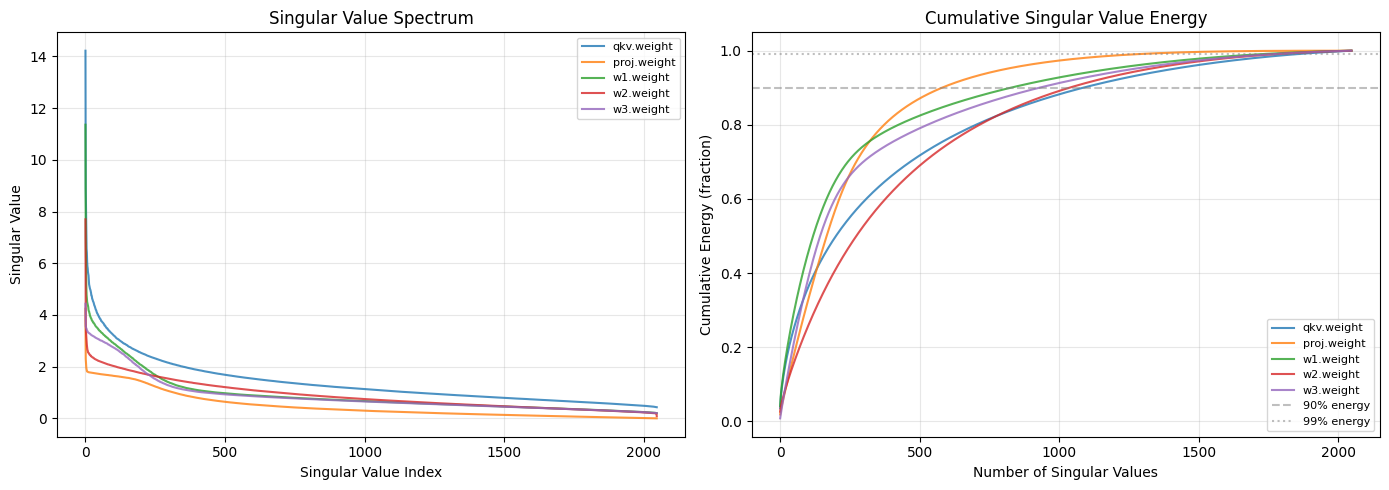


Singular Value Statistics:
qkv.weight          : shape=torch.Size([6144, 2048]), rank_90=1086, rank_99=1840, full_rank=2048
proj.weight         : shape=torch.Size([2048, 2048]), rank_90= 581, rank_99=1263, full_rank=2048
w1.weight           : shape=torch.Size([4096, 2048]), rank_90= 827, rank_99=1708, full_rank=2048
w2.weight           : shape=torch.Size([2048, 4096]), rank_90=1037, rank_99=1759, full_rank=2048
w3.weight           : shape=torch.Size([4096, 2048]), rank_90= 929, rank_99=1750, full_rank=2048


In [18]:
# Example 1: Analyze all components of layer 0
results = analyze_layer(CHECKPOINT_PATH, layer_idx=0)

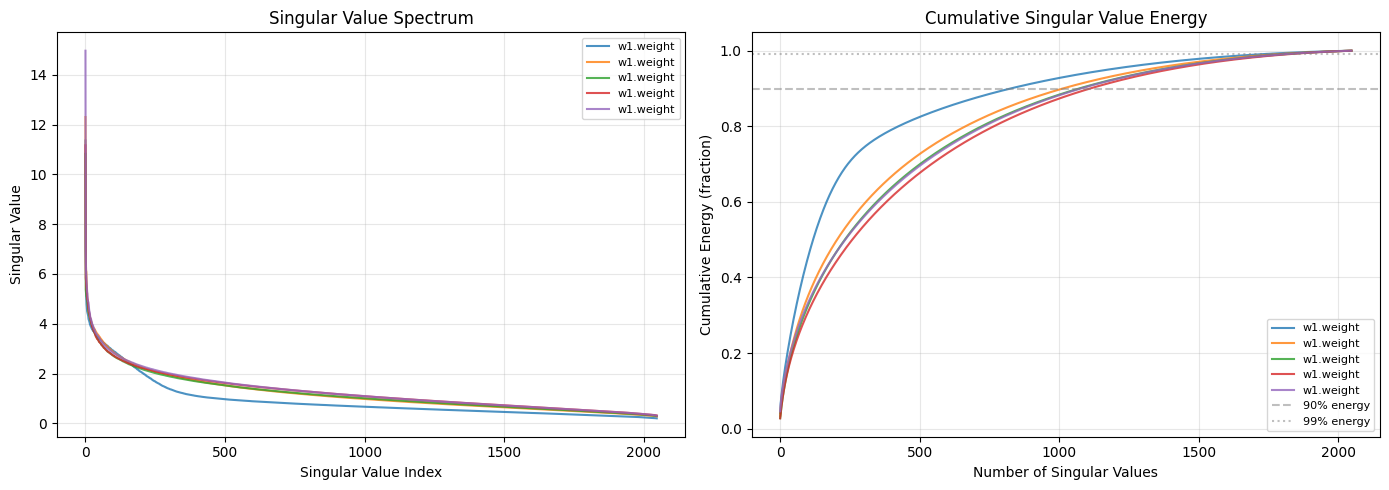


Singular Value Statistics:
w1.weight           : shape=torch.Size([4096, 2048]), rank_90= 827, rank_99=1708, full_rank=2048
w1.weight           : shape=torch.Size([4096, 2048]), rank_90=1014, rank_99=1769, full_rank=2048
w1.weight           : shape=torch.Size([4096, 2048]), rank_90=1072, rank_99=1793, full_rank=2048
w1.weight           : shape=torch.Size([4096, 2048]), rank_90=1112, rank_99=1808, full_rank=2048
w1.weight           : shape=torch.Size([4096, 2048]), rank_90=1079, rank_99=1794, full_rank=2048


In [19]:
# Example 2: Compare FFN w1 across layers 0, 4, 8, 12, 15
results = compare_layers(CHECKPOINT_PATH, layer_indices=[0, 4, 8, 12, 15], component='ff.w1')

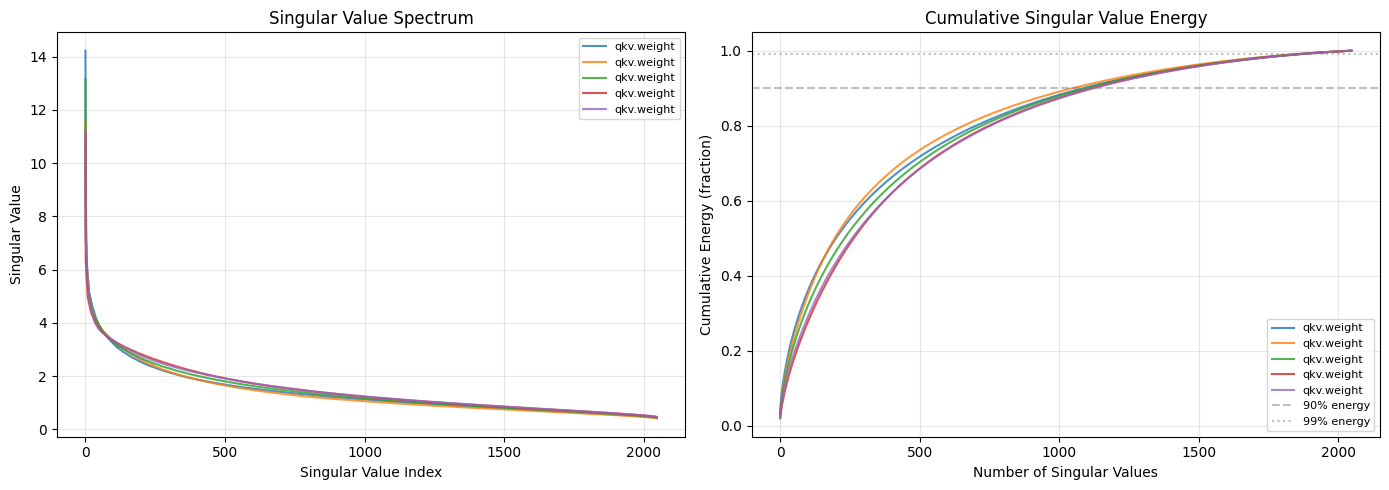


Singular Value Statistics:
qkv.weight          : shape=torch.Size([6144, 2048]), rank_90=1086, rank_99=1840, full_rank=2048
qkv.weight          : shape=torch.Size([6144, 2048]), rank_90=1049, rank_99=1834, full_rank=2048
qkv.weight          : shape=torch.Size([6144, 2048]), rank_90=1100, rank_99=1846, full_rank=2048
qkv.weight          : shape=torch.Size([6144, 2048]), rank_90=1120, rank_99=1851, full_rank=2048
qkv.weight          : shape=torch.Size([6144, 2048]), rank_90=1123, rank_99=1852, full_rank=2048


In [20]:
# Example 3: Compare attention QKV across layers
results = compare_layers(CHECKPOINT_PATH, layer_indices=[0, 4, 8, 12, 15], component='attn.qkv')

In [21]:
# Example 4: Custom analysis - specific matrices
results = analyze_singular_values(
    CHECKPOINT_PATH,
    layer_names=[
        'layers.0.ff.w1.weight',
        'layers.15.ff.w1.weight',
        'embed.weight',
    ],
    normalize=True,
    log_scale=True,
)

KeyError: "Weight 'embed.weight' not found. Use list_weight_matrices() to see available weights."